# Sophisticated inference on Graph Worlds

This notebook demonstrates tree searching policies with sophisticated active inference.

We create a `GraphEnv`, where an agent can move between locations on a graph, and see objects at the location it is at.

In [1]:
import jax.numpy as jnp
import jax.tree_util as jtu
from jax import random as jr

key = jr.PRNGKey(0)

In [2]:
import networkx as nx
from pymdp.envs import GraphEnv
from pymdp.envs.graph_worlds import generate_connected_clusters

graph, _ = generate_connected_clusters(cluster_size=3, connections=2)
env = GraphEnv(graph, object_locations=[4], agent_locations=[0])

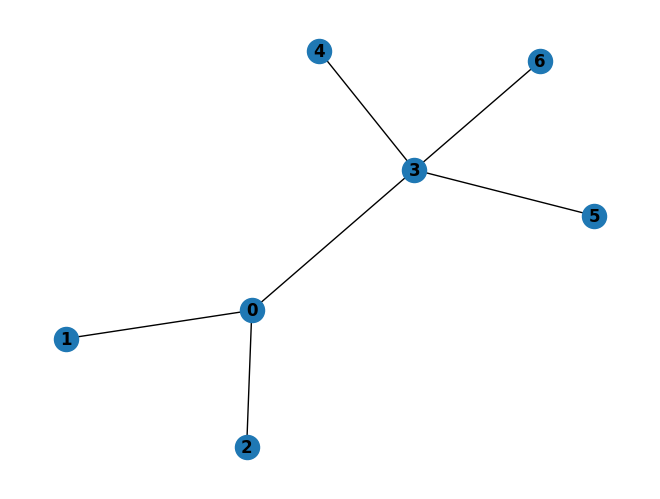

In [3]:
nx.draw(graph, with_labels=True, font_weight="bold")

Let's create an agent, we give the agent a prior on the object location to showcase the planning depth and pruning. We let the agent start at location 0, and give it a prior about where the object is (location 4).

In [4]:
from pymdp.agent import Agent

A = [a.copy() for a in env.params["A"]]
B = [b.copy() for b in env.params["B"]]
A_dependencies = env.dependencies["A"]
B_dependencies = env.dependencies["B"]

C = [jnp.zeros(a.shape[:2]) for a in A]
C[1] = C[1].at[1].set(1.0)

D = [jnp.ones(b.shape[:2]) for b in B]
D[0] = D[0].at[0, 0].set(100.0)
D[1] = D[1].at[0, 4].set(10.0)
D = jtu.tree_map(lambda x: x / x.sum(), D)

agent = Agent(A, B, C, D, A_dependencies=A_dependencies, B_dependencies=B_dependencies, policy_len=1)

In [5]:
keys = jr.split(key, 2)
key = keys[0]
obs, env = env.reset(keys[1:])

In [6]:
empirical_prior = agent.D

qs = agent.infer_states(
    observations=obs,
    past_actions=None,
    empirical_prior=empirical_prior,
    qs_hist=None,
)

Now we can call the `tree_search` method and visualize the planning tree.

In [7]:
from pymdp.planning.si import tree_search

tree = tree_search(agent, qs, horizon=2, policy_prune_threshold=1/16, observation_prune_threshold=1/16, gamma=5)

In [8]:
import matplotlib.pyplot as plt

def observation_label(o):
    return "location: " + str(o[0][0, 0]) + "\n object: " + str(o[1][0,0])

def policy_label(a):
    return "move \n to: "+ str(a[0])

def plot_plan_tree(
    tree,
    prob_threshold=0.2
):
    root_node = tree.root()

    colormap = plt.cm.Blues
    colormap_policy = plt.cm.Reds

    # create graph
    count = 0
    G = nx.Graph()
    to_visit = [(root_node, 0)]
    labels = {}
    colors = []

    G.add_node(count)
    labels[0] = ""
    colors.append((0.0, 0.0, 0.0, 1.0))
    count += 1

    # visit children
    while len(to_visit) > 0:
        node, id = to_visit.pop()
        for child in node["children"]:
            prob = child.get("prob", 0)
            if prob < prob_threshold:
                continue

            G.add_node(count)
            G.add_edge(id, count)

            cm = colormap
            if "policy" in child.keys():
                a = child["policy"]
                labels[count] = policy_label(a)
                cm = colormap_policy
            elif "observation" in child.keys():
                o = child["observation"]
                labels[count] = observation_label(o)
            else:
                labels[count] = ""


            r, g, b, a = cm(child.get("prob", 0))
            colors.append((r, g, b, 0.5))

            to_visit.append((child, count))
            count += 1.0


    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")
    nx.draw(
        G,
        pos,
        with_labels=True,
        font_size=8,
        labels=labels,
        node_color=colors,
    )

Given the agent prior, it should commit to going to location 4, expecting to see the object there.

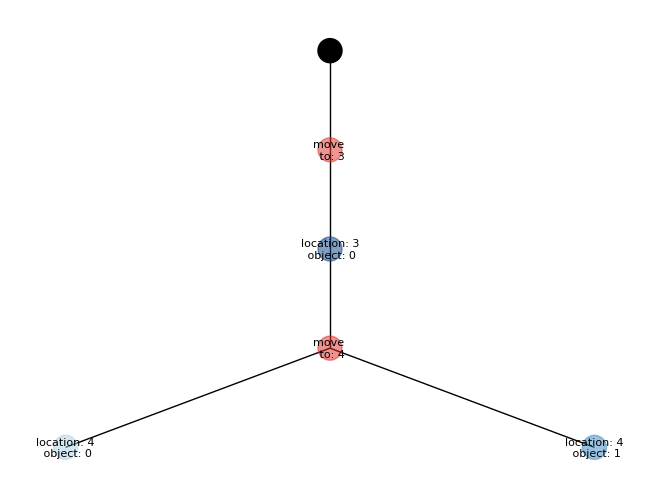

In [9]:
plot_plan_tree(tree, prob_threshold=0.2)

The `si_policy_search` returns a method that yields a qpi, that can be effectively used in an active inference loop. Unfortunately this doesn't yet work with the `rollout` function as it is not properly jit'able yet.

In [10]:
from pymdp.planning.si import si_policy_search

# TODO we cannot yet use this with rollout as it cannot be jit-ed
# last, result, env = rollout(agent, env, 10, key, policy_search=si_policy_search(max_depth=3))

However, we can use our own for loop and call `infer_and_plan` with a `si_policy_search` function.

In [ ]:
import jax.tree_util as jtu
from pymdp.envs.rollout import infer_and_plan

rng_key = jr.PRNGKey(0)

policy_search=si_policy_search(max_depth=2, gamma=5)

# start with no action (indicated by all -1's), and expand agent.D to add time dimension
action = -jnp.ones((agent.batch_size, len(agent.num_controls)), dtype=jnp.int32)
qs = jtu.tree_map(lambda x: jnp.expand_dims(x, -2), agent.D)

# reset environment and get initial observation
keys = jr.split(rng_key, agent.batch_size + 1)
rng_key = keys[0]
observation, env = env.reset(keys[1:])

for i in range(5):
    # random keys
    keys = jr.split(rng_key, agent.batch_size + 2)
    rng_key = keys[0]

    # infer and plan
    agent, action, qs, _ = infer_and_plan(agent, qs, observation, action, keys[1], policy_search=policy_search)

    # step the environment
    observation, env = env.step(keys[2:], action)

    print(f"Step {i+1}: Action taken: {action}, Observation: {observation}")

Step 1: Action taken: [[3 0]], Observation: [Array([[3.]], dtype=float32), Array([[0.]], dtype=float32)]
Step 2: Action taken: [[4 0]], Observation: [Array([[4.]], dtype=float32), Array([[1.]], dtype=float32)]
Step 3: Action taken: [[0 0]], Observation: [Array([[4.]], dtype=float32), Array([[1.]], dtype=float32)]
Step 4: Action taken: [[0 0]], Observation: [Array([[4.]], dtype=float32), Array([[1.]], dtype=float32)]
Step 5: Action taken: [[0 0]], Observation: [Array([[4.]], dtype=float32), Array([[1.]], dtype=float32)]
